# Signate開始時のお約束

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [ ]:
!pip install signate

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=b3ef8a017ec692f7d23562860b10de0f68a301a043e234960d56a135b047d498
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [ ]:
!signate files --competition-id=1523

  fileId  name               title                     size  updated_at
--------  -----------------  ----------------------  ------  -------------------
    3939  train.csv          学習用データ            494008  2024-08-01 12:00:28
    3940  test.csv           評価用データ            488363  2024-08-01 12:00:38
    3944  sample_submit.csv  応募用サンプルファイル   86893  2024-08-01 12:00:49
    4057  tutorial.ipynb     チュートリアルコード    323126  2024-08-01 12:01:00


In [ ]:
!signate download --competition-id=1523

sample_submit.csv

tutorial.ipynb

test.csv

train.csv


Download completed.


In [ ]:
!pip install kanjize

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 15.1 MB/s eta 0:00:00


In [ ]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# データフレーム読み込み
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

In [ ]:
# データ結合(番号を振り直す)
all_df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
max_row = len(all_df)

<ipython-input-88-8331b9fb236d>:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())


<Axes: >

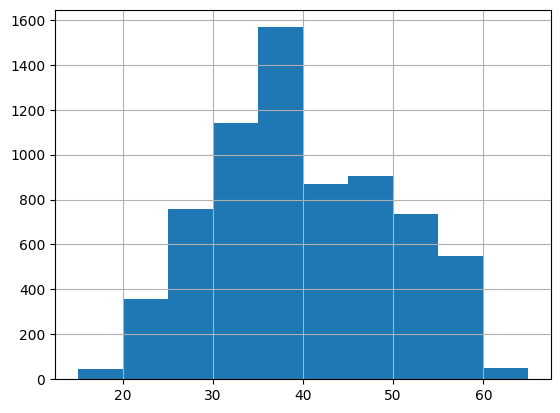

In [ ]:
###############
# "Age"の処理 #
###############
import unicodedata # 全角を半角に変換
from kanjize import kanji2number # 漢字を数値に変換
import re

# 漢字の判定用
p = re.compile('[一二三四五六七八九十]+')

# nanを-1歳で補完
all_df["Age"] = all_df["Age"].fillna("-1歳")

# Ageの処理
for i in range(max_row):

  # 末尾文字の取得
  tail = all_df.loc[i,"Age"][-1:]

  # 先頭文字が漢字の場合
  if(p.search(all_df.loc[i,"Age"][0])!=None):
    tmp = all_df.loc[i,"Age"][:-1]
    all_df.loc[i,"Age"] = kanji2number(tmp)
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 末尾文字が歳、才、際の場合
  elif((tail=="歳")or(tail=="才")or(tail=="際")):
    all_df.loc[i,"Age"] = all_df.loc[i,"Age"][:-1]
    # 全角を半角に直す
    all_df.loc[i,"Age"] = unicodedata.normalize("NFKC", all_df.loc[i,"Age"])
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 代の場合
  elif(tail == "代"):
    tmp = all_df.loc[i,"Age"][:-1]

    # 「代」は○5歳に変換する
    tmp = int(tmp)
    # 10歳で分けて5足す
    tmp = tmp//10 * 10
    all_df.loc[i,"Age"] = tmp + 5
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

# 「-1」はそれ以外の中央値を代入
all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())

# int型にキャストする
all_df["Age"] = all_df["Age"].astype(int)

# ヒストグラムを描く
all_df["Age"].hist()

In [ ]:
#########################
# "TypeofContact"の処理 #
#########################
# 欠損は最頻値で補完する
all_df["TypeofContact"] = all_df["TypeofContact"].fillna("Self Enquiry")
all_df["TypeofContact"] = all_df["TypeofContact"].astype("category")
print(all_df["TypeofContact"].value_counts())

TypeofContact
Self Enquiry       4462
Company Invited    2516
Name: count, dtype: int64


In [ ]:
#########################
# "CityTier"の処理 #
#########################
print(all_df["CityTier"].value_counts())

CityTier
2    3160
1    2991
3     827
Name: count, dtype: int64


In [ ]:
#########################
# "DurationOfPitch"の処理 #
#########################
# nanを-1分で補完
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].fillna("-1分")

# 秒を分に変換 #
for i in range(max_row):

  tail = str(all_df.loc[i,"DurationOfPitch"])[-1:]

  if(tail == "秒"):
    tmp = all_df.loc[i,"DurationOfPitch"][:-1]
    all_df.loc[i,"DurationOfPitch"] = float(tmp) / 60.0
  elif(tail == "分"):
    all_df.loc[i,"DurationOfPitch"] = all_df.loc[i,"DurationOfPitch"][:-1]

all_df["DurationOfPitch"] = all_df["DurationOfPitch"].astype("float64")

# 「-1」はそれ以外の中央値を代入
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].replace(-1,all_df.loc[all_df["DurationOfPitch"]>0,"DurationOfPitch"].median())

# 重要でないため、10分刻みのカテゴリにする
all_df["DurationOfPitch"] = (all_df["DurationOfPitch"].values // 10).astype(int)

# 分布を確認する
print(all_df["DurationOfPitch"].value_counts())

DurationOfPitch
1    3824
0    1984
2     709
3     461
Name: count, dtype: int64


In [ ]:
####################
# "Occupation"の処理 #
####################
all_df["Occupation"] = all_df["Occupation"].astype("category")
print(all_df["Occupation"].value_counts())

Occupation
Small Business    3456
Salaried          2801
Large Business     721
Name: count, dtype: int64


In [ ]:
##################
# "Genger"の処理 #
##################
# 先頭文字がMかmならMaleになる
for i in range(max_row):

  # 先頭文字の取得(半角)
  head = unicodedata.normalize("NFKC", all_df.loc[i,"Gender"][:1])
  if(head == "m"):
    all_df.loc[i,"Gender"] = "Male"
  else:
    all_df.loc[i,"Gender"] = "Female"

# カテゴリ型にキャスト
all_df["Gender"] = all_df["Gender"].astype("category")
print(all_df["Gender"].value_counts())

Gender
Female    5946
Male      1032
Name: count, dtype: int64


In [ ]:
##################################
# "NumberOfPersonVisiting"の処理 #
##################################
print(all_df["NumberOfPersonVisiting"].value_counts())

NumberOfPersonVisiting
2.0    3163
3.0    2773
1.0     686
4.0     356
Name: count, dtype: int64


In [ ]:
##################################
# "NumberOfFollowups"の処理 #
##################################

# 欠損を-1で埋めてから中央値を取る
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].fillna(-1)
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].replace(-1,all_df.loc[all_df["NumberOfFollowups"]>0,"NumberOfFollowups"].median())

# 100回以上は記録違いとして100で割る
all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] = all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] / 100

# int型に変換
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].astype(int)

# 分布の確認
print(all_df["NumberOfFollowups"].value_counts())

NumberOfFollowups
4.0    2834
3.0    2561
5.0    1122
2.0     213
1.0     178
6.0      70
Name: count, dtype: int64


In [ ]:
##########################
# "ProductPitched"の処理 #
##########################
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdib"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

# Basic, Standard, Deluxe, Super Deluxe, kingに分ける
prefix = 0
others = []
# すべて小文字に変換し判定
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"ProductPitched"][:2].lower())).lower()

  if(prefix == "ba"):
    all_df.loc[i,"ProductPitched"] = "Basic"

  elif(prefix == "st"):
    all_df.loc[i,"ProductPitched"] = "Standard"

  elif(prefix == "de"):
    all_df.loc[i,"ProductPitched"] = "Deluxe"

  elif(prefix == "su"):
    all_df.loc[i,"ProductPitched"] = "SuperDeluxe"

  elif(prefix == "ki"):
    all_df.loc[i,"ProductPitched"] = "King"

  else:
    others.append(i)

all_df["ProductPitched"] = all_df["ProductPitched"].astype("category")

# 分布の確認
print(all_df["ProductPitched"].value_counts())

ProductPitched
Basic          2347
Deluxe         2091
Standard       1614
SuperDeluxe     640
King            286
Name: count, dtype: int64


In [ ]:
#################################
# "PreferredPropertyStar"の処理 #
#################################
# 分布を確認する
all_df["PreferredPropertyStar"].value_counts()

,count
PreferredPropertyStar,
3.0,4328
4.0,2254
5.0,396


In [ ]:
#########################
# "NumberOfTrips"の処理 #
#########################
# nanは-1で補完
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].fillna("-1")

# 一旦オブジェクト型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("object")

for i in range(max_row):

  # 先頭文字の取得(半角)
  head = all_df.loc[i,"NumberOfTrips"][:1]

  if(head == "年"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][2:3]

  elif(head == "半"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][3:4]

  elif(head == "四"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][4:5]

# int型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("int")

# 「-1」はそれ以外の中央値を代入
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].replace(-1,all_df.loc[all_df["NumberOfTrips"]>0,"NumberOfTrips"].median())

# 分布を確認する
all_df["NumberOfTrips"].value_counts()

,count
NumberOfTrips,
2,2250
3,1770
5,977
1,834
7,513
4,327
6,281
8,26


In [ ]:
#########################
# "Passport"の処理 #
#########################
all_df["Passport"] = all_df["Passport"].astype("category")
print(all_df["Passport"].value_counts())

Passport
0    6288
1     690
Name: count, dtype: int64


In [ ]:
##################################
# "PitchSatisfactionScore"の処理 #
##################################
print(all_df["PitchSatisfactionScore"].value_counts())

PitchSatisfactionScore
2    2500
4    1452
1    1439
3    1344
5     243
Name: count, dtype: int64


In [ ]:
#########################
# "Designation"の処理 #
#########################

# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡Аае"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdibaae"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

# 文字を変換する
prefix = 0
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"Designation"][:1].lower())).lower()

  # Executive: 取締役、執行役員
  if(prefix == "e"):
    all_df.loc[i,"Designation"] = "Executive"

  # Vice President: 本部長
  elif(prefix == "v"):
    all_df.loc[i,"Designation"] = "VP"

  # Associate Vice President: 本部長補佐
  elif(prefix == "a"):
    all_df.loc[i,"Designation"] = "AVP"

  # Senior Manager: 次長
  elif(prefix == "s"):
    all_df.loc[i,"Designation"] = "Senior Manager"

  # Manager: 課長
  elif(prefix == "m"):
    all_df.loc[i,"Designation"] = "Manager"

all_df["Designation"] = all_df["Designation"].astype("category")

# 分布の確認
print(all_df["Designation"].value_counts())

,count
Designation,
Executive,2330
Manager,2117
Senior Manager,1632
AVP,635
VP,264


<Axes: >

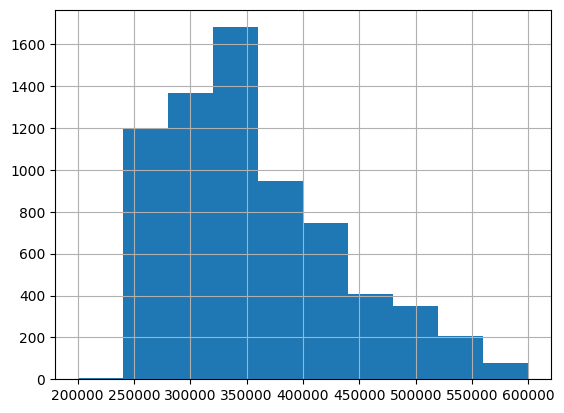

In [ ]:
#########################
# "MonthlyIncome"の処理 #
#########################
import re

# 漢字の判定用
p = re.compile('[月]+')

# nanを-1で補完
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].fillna("-1")

for i in range(max_row):

  # 先頭文字の取得
  head = all_df.loc[i,"MonthlyIncome"][:1]

  # 先頭文字が漢字の場合
  if(p.search(head[0])!=None):
    tmp = all_df.loc[i,"MonthlyIncome"][2:-2]
    all_df.loc[i,"MonthlyIncome"] = float(tmp)*10000

# float型にキャストする
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].astype(float)

# 「-1」はそれ以外の中央値を代入
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].replace(-1,all_df.loc[all_df["MonthlyIncome"]>0,"MonthlyIncome"].median())

# 分布の確認
all_df["MonthlyIncome"].hist()

In [ ]:
#########################
# "customer_info"の処理 #
#########################
import re

# 項目名
cont = []

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      if(tmp[j] not in cont):
        cont.append(tmp[j])

# キーワード抽出
c_car = [] # 車関係
c_child = [] # 子供関係
c_married = [] # 婚姻関係
c_other = [] # その他

for i in range(len(cont)):
  # 「車あり」、「車所持」、「自家用車あり」、「車保有」、「乗用車所持」、「自動車保有」
  # 「車なし」、「車未所持」、「自家用車なし」、「車保有なし」、「乗用車なし」、「自動車未所有」
  if((cont[i][0:1] == "車") or (cont[i][0:1] == "自") or (cont[i][0:1] == "乗")):
    c_car.append(cont[i])
  # 「こども1人」、「1児」、「子供1人」、「子供有り(1人)」、「子供有り」
  # 「こども2人」、「2児」、「子供2人」、「子供有り(2人)」
  # 「こども3人」、「3児」「子供3人」、「子供有り(3人)」
  # 「子供なし」、「子供無し」、「無子」、「子供ゼロ」、「非児童家庭」
  # 「子育て状況不明」、「子の数不詳」、「子供の数不明」
  elif((cont[i][0:1] == "子") or (cont[i][0:1] == "こ") or (cont[i][-1:] == "児") or (cont[i][-1:] == "子") or (cont[i][-1:] == "庭")):
    c_child.append(cont[i])
  # 「結婚済み」、「離婚済み」、「未婚」、「独身」
  elif((cont[i][0:1] == "結") or (cont[i][0:1] == "離") or (cont[i][0:1] == "独") or (cont[i][0:1] == "離") or (cont[i][0:1] == "未")):
    c_married.append(cont[i])
  # 「1人」、「2人」、「3人」、「不明」、「わからない」
  else:
    c_other.append(cont[i])

In [ ]:
# 新たなカラムを追加
all_df["CarHolder"] = 0 # 車所有
all_df["NumofChild"] = 0 # 子供の数
all_df["Married"] = "Single" # 婚姻歴

# 車
c_car_hold = ["車あり","車所持","自家用車あり","車保有","乗用車所持","自動車保有"]

# 子供
c_child_1 = ["こども1人","1児""子供1人","子供有り(1人)","子供有り"]
c_child_2 = ["こども2人","2児""子供2人","子供有り(2人)"]
c_child_3 = ["こども3人","3児""子供3人","子供有り(3人)"]

# 婚姻状況
c_pair = ["結婚済み"]
c_batu = ["離婚済み"]

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      # 車の情報
      if(tmp[j] in c_car_hold):
        all_df.loc[i, "CarHolder"] = 1
      # 子供の情報
      if(tmp[j] in c_child_1):
        all_df.loc[i, "NumofChild"] = 1
      if(tmp[j] in c_child_2):
        all_df.loc[i, "NumofChild"] = 2
      if(tmp[j] in c_child_3):
        all_df.loc[i, "NumofChild"] = 3
      # 婚姻歴
      if(tmp[j] in c_pair):
        all_df.loc[i, "Married"] = "Married"
      if(tmp[j] in c_batu):
        all_df.loc[i, "Married"] = "Divorce"

# 使用済みカラム抹消
all_df = all_df.drop("customer_info", axis=1)

In [ ]:
# 車保有率
all_df["CarHolder"] = all_df["CarHolder"].astype("category")
print(all_df["CarHolder"].value_counts())

CarHolder
0    4408
1    2570
Name: count, dtype: int64


In [ ]:
# 子供の数
print(all_df["NumofChild"].value_counts())

NumofChild
0    5015
1    1347
2     571
3      45
Name: count, dtype: int64


In [ ]:
# 婚姻歴
all_df["Married"] = all_df["Married"].astype("category")
print(all_df["Married"].value_counts())

Married
Married    2846
Single     2444
Divorce    1688
Name: count, dtype: int64


In [ ]:
all_df.columns

Index(['id', 'Age', 'TypeofContact', 'CityTier', 'DurationOfPitch',
       'Occupation', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'ProdTaken',
       'CarHolder', 'NumofChild', 'Married'],
      dtype='object')

In [ ]:
all_df.dtypes

,0
id,int64
Age,int64
TypeofContact,category
CityTier,int64
DurationOfPitch,int64
Occupation,category
Gender,category
NumberOfPersonVisiting,float64
NumberOfFollowups,int64
ProductPitched,category


In [ ]:
# 順番を整列させる
col = ['id', 'Age', 'TypeofContact', 'CityTier', 'DurationOfPitch',
       'Occupation', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'ProdTaken',
       'CarHolder', 'NumofChild', 'Married']

all_df = all_df.reindex(columns=col)

In [ ]:
all_df_num = all_df.loc[:,(all_df.dtypes == "float64") | (all_df.dtypes == "int")]

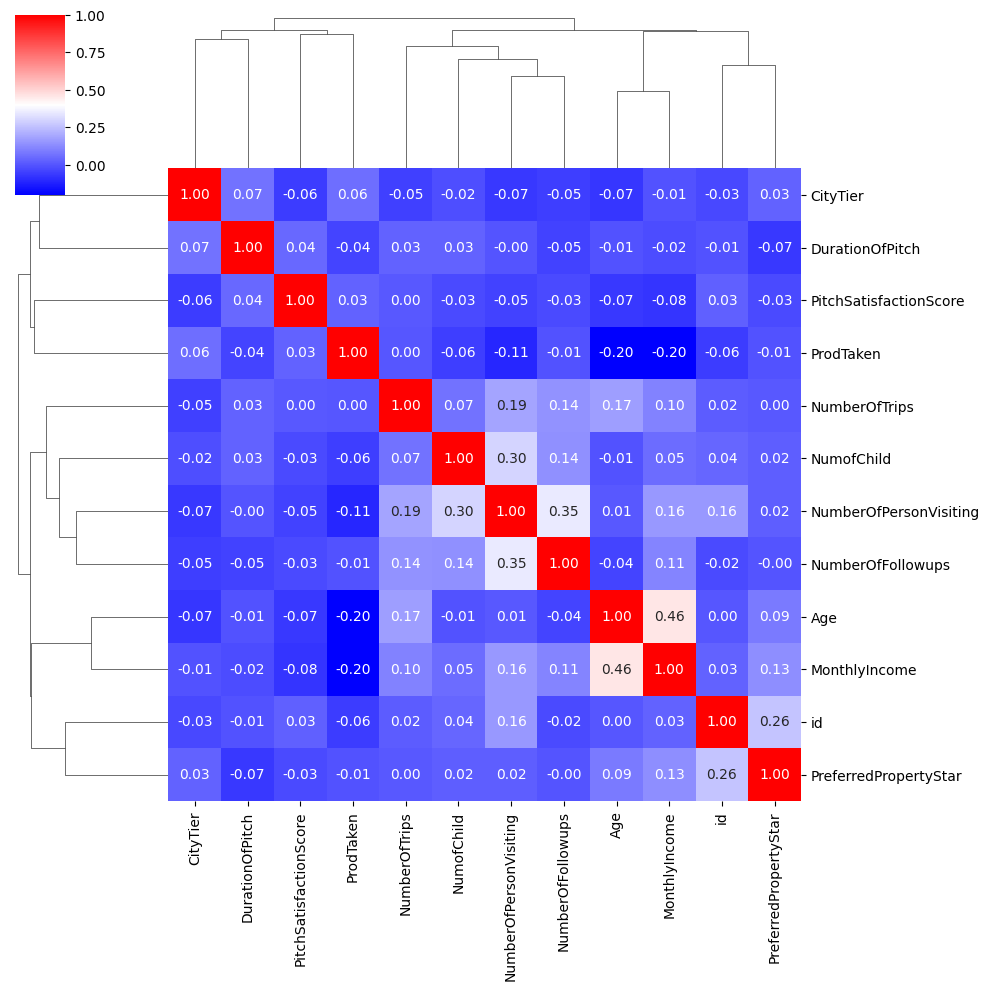

In [ ]:
# 相関係数を確認する
import seaborn as sns
import matplotlib.pyplot as plt

all_df_corr = all_df_num.corr()
sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

# 特徴量エンジニアリング

# 学習準備

In [ ]:
#-------------------------------------------------------------------------------------------
# カテゴリ列 x 13
# CompanyInvited, CityTier, DurationOfPitch, Salaried, Male, ProductPitched, PreferredPropertyStar,
# NumberOfTrips, Passport, PitchSatisfactionScore, Designation, CarHolder, Single
# 数値列 x 5
# Age, NumberOfPersonVisiting, NumberOfFollowups, MonthlyIncome, NumofChild
#-------------------------------------------------------------------------------------------
all_df.columns

Index(['id', 'Age', 'TypeofContact', 'CityTier', 'DurationOfPitch',
       'Occupation', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'ProdTaken',
       'CarHolder', 'NumofChild', 'Married'],
      dtype='object')

In [ ]:
# 順番を整列させる
col = ['id', 'Age', 'TypeofContact', 'CityTier', 'DurationOfPitch',
       'Occupation', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'ProdTaken',
       'CarHolder', 'NumofChild', 'Married']

# col = ['id', 'Age', 'CompanyInvited', 'CityTier', 'DurationOfPitch',
#        'Salaried', 'Male', 'NumberOfPersonVisiting', 'NumberOfFollowups',
#        'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
#        'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'CarHolder',
#        'NumofChild', 'Single', 'ProdTaken']

all_df = all_df.reindex(columns=col)

In [ ]:
len(all_df.columns)

20

# ここから学習作業

In [ ]:
# 取り除く変数
RMV = ["id","ProdTaken"]
RMV2 = ["id"]

FEATURES = [c for c in all_df.columns if c not in RMV2]
TARGET = "ProdTaken"

In [ ]:
CATS = []
for c in FEATURES:
  if all_df[c].dtype == "category":
    CATS.append(c)
print(CATS)

['TypeofContact', 'Occupation', 'Gender', 'ProductPitched', 'Passport', 'Designation', 'CarHolder', 'Married']


In [ ]:
# オブジェクト型はint型に変換する
# all_df[CATS] = all_df[CATS].astype(int)

In [ ]:
# カラムを制限
all_df2 = all_df[FEATURES]

# 結合を戻す
train = all_df2.iloc[:len(train_df)].copy()
test = all_df2.iloc[len(train_df):].reset_index(drop=True).copy()

# 対象の列のみ取り込み
test = test.drop(TARGET,axis=1)
FEATURES = test.columns

In [ ]:
!pip install optuna

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 24.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import optuna
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from sklearn.model_selection import train_test_split, StratifiedKFold
import sklearn.metrics

In [ ]:
all_df.columns

Index(['id', 'Age', 'TypeofContact', 'CityTier', 'DurationOfPitch',
       'Occupation', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'ProdTaken',
       'CarHolder', 'NumofChild', 'Married'],
      dtype='object')

In [ ]:
y = train["ProdTaken"]
X = train.drop(["ProdTaken"], axis=1)

In [ ]:
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

In [ ]:
categorical_features

['TypeofContact',
 'Occupation',
 'Gender',
 'ProductPitched',
 'Passport',
 'Designation',
 'CarHolder',
 'Married']

In [ ]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

def objective(trial):

  params = {
        'iterations' : trial.suggest_int('iterations', 50, 300),
        'depth' : trial.suggest_int('depth', 4, 10),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait' :trial.suggest_int('od_wait', 10, 50),
        'eval_metric' :'AUC',
    }

  # KFold
  cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
  auc_score = []
  pred_score = []
  pred_test_df = test_df.drop(["id"], axis=1)

  for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), start=0):
      X_train = X.iloc[train_idx, :]
      y_train = y[train_idx]
      X_val = X.iloc[val_idx, :]
      y_val = y[val_idx]

      cb_model = CatBoostClassifier(**params)

      cb_model.fit(
            X_train, y_train,
            cat_features=categorical_features,
            eval_set=(X_val, y_val),
            use_best_model=True,
            verbose=False,
          )

      # AUC算出
      auc_score.append(cb_model.get_best_score()["validation"]["AUC"])
      # # testデータのスコア算出
      # pred_score.append(cb_model.predict_proba(pred_test_df)[:,1])

  return sum(auc_score)/len(auc_score)

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2025-05-30 13:26:26,811] A new study created in memory with name: no-name-2968e0c8-3e99-44f3-8111-4daa517f23f5
<ipython-input-146-2bad3c416e1a>:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-146-2bad3c416e1a>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
[I 2025-05-30 13:26:28,148] Trial 0 finished with value: 0.8096037649874381 and parameters: {'iterations': 64, 'depth': 9, 'learning_rate': 0.043974003607205096, 'random_strength': 24, 'bagging_temperature': 1.3853302264707958, 'od_type': '

In [ ]:
print(study.best_trial)
print(study.best_params)

FrozenTrial(number=93, state=1, values=[0.8453683426039393], datetime_start=datetime.datetime(2025, 5, 30, 13, 31, 7, 764465), datetime_complete=datetime.datetime(2025, 5, 30, 13, 31, 9, 306631), params={'iterations': 191, 'depth': 4, 'learning_rate': 0.2095830805712901, 'random_strength': 6, 'bagging_temperature': 27.557702959072845, 'od_type': 'Iter', 'od_wait': 28}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=300, log=False, low=50, step=1), 'depth': IntDistribution(high=10, log=False, low=4, step=1), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None), 'random_strength': IntDistribution(high=100, log=False, low=0, step=1), 'bagging_temperature': FloatDistribution(high=100.0, log=True, low=0.01, step=None), 'od_type': CategoricalDistribution(choices=('IncToDec', 'Iter')), 'od_wait': IntDistribution(high=50, log=False, low=10, step=1)}, trial_id=93, value=None)
{'iterations': 191, 'depth': 4, 'learn

In [ ]:
best_params = study.best_params

In [ ]:
best_params['eval_metric'] = 'AUC'

In [ ]:
best_params

{'iterations': 191,
 'depth': 4,
 'learning_rate': 0.2095830805712901,
 'random_strength': 6,
 'bagging_temperature': 27.557702959072845,
 'od_type': 'Iter',
 'od_wait': 28,
 'eval_metric': 'AUC'}

In [ ]:
train_pred_df = pd.DataFrame()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_score = []
pred_score = []
pred_test_df = test
models = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), start=0):
    X_train = X.iloc[train_idx, :]
    y_train = y[train_idx]
    X_val = X.iloc[val_idx, :]
    y_val = y[val_idx]

    cb_model = CatBoostClassifier(**best_params)

    cb_model.fit(
         X_train, y_train,
         cat_features=categorical_features,
         eval_set=(X_val, y_val),
         use_best_model=True,
         verbose=True,
        )

    models.append(cb_model)

    # AUC算出
    auc_score.append(cb_model.get_best_score()["validation"]["AUC"])
    # testデータのスコア算出
    pred_score.append(cb_model.predict_proba(pred_test_df)[:,1])
    # trainデータのスコア算出
    pred_valid = cb_model.predict_proba(X_val)[:,1]
    tmp_df = pd.DataFrame(
        {
            "catboost_Score": pred_valid,
            "true": y_val,
        },
        index=X_val.index,
    )
    train_pred_df = pd.concat([train_pred_df, tmp_df], axis=0)
train_pred_df = train_pred_df.sort_index()

0:	test: 0.4797408	best: 0.4797408 (0)	total: 1.49ms	remaining: 283ms
1:	test: 0.5618645	best: 0.5618645 (1)	total: 3.19ms	remaining: 301ms
2:	test: 0.5933612	best: 0.5933612 (2)	total: 4.45ms	remaining: 279ms
3:	test: 0.5919064	best: 0.5933612 (2)	total: 5.47ms	remaining: 256ms
4:	test: 0.5931522	best: 0.5933612 (2)	total: 6.62ms	remaining: 246ms
5:	test: 0.6032358	best: 0.6032358 (5)	total: 7.77ms	remaining: 240ms
6:	test: 0.7042726	best: 0.7042726 (6)	total: 8.96ms	remaining: 236ms
7:	test: 0.7046154	best: 0.7046154 (7)	total: 10.2ms	remaining: 232ms
8:	test: 0.7120903	best: 0.7120903 (8)	total: 11.4ms	remaining: 231ms
9:	test: 0.7477843	best: 0.7477843 (9)	total: 12.6ms	remaining: 229ms
10:	test: 0.7678344	best: 0.7678344 (10)	total: 13.5ms	remaining: 220ms
11:	test: 0.7672993	best: 0.7678344 (10)	total: 14.3ms	remaining: 213ms
12:	test: 0.7990134	best: 0.7990134 (12)	total: 15.6ms	remaining: 213ms
13:	test: 0.8049498	best: 0.8049498 (13)	total: 16.8ms	remaining: 212ms
14:	test: 0.

In [ ]:
auc_score

[0.8321070234113712,
 0.8522909698996656,
 0.8135444596212542,
 0.8336115748469671,
 0.8407655146785582]

In [ ]:
sum(auc_score)/len(auc_score)

0.8344639084915633

In [ ]:
average_pred = np.mean(pred_score, axis=0)

In [ ]:
print(pred_score)
print(average_pred)

[array([0.09542252, 0.18909911, 0.31766977, ..., 0.45763859, 0.1687641 ,
       0.01690535]), array([0.09092866, 0.2304916 , 0.2398124 , ..., 0.50458312, 0.18390821,
       0.02662073]), array([0.08694823, 0.30633849, 0.24615376, ..., 0.64555598, 0.22879339,
       0.01678685]), array([0.11130036, 0.24745883, 0.17849338, ..., 0.57355044, 0.16312861,
       0.01342402]), array([0.06272579, 0.19245036, 0.32659262, ..., 0.65663034, 0.22685497,
       0.01028161])]
[0.08946511 0.23316768 0.26174439 ... 0.56759169 0.19428986 0.01680371]


In [ ]:
submit_df = pd.read_csv("/content/sample_submit.csv", header=None)
submit_df.head()

,0,1
0,3489,0.119451
1,3490,0.343575
2,3491,0.119451
3,3492,0.119451
4,3493,0.119451


In [ ]:
submit_df[1] = average_pred

In [ ]:
submit_df.head()

,0,1
0,3489,0.089465
1,3490,0.233168
2,3491,0.261744
3,3492,0.395044
4,3493,0.298626


In [ ]:
submit_df.to_csv("submit.csv", index=False, header=None)

# 重要度を比較する

In [ ]:
CATS

['TypeofContact',
 'Occupation',
 'Gender',
 'ProductPitched',
 'Passport',
 'Designation',
 'CarHolder',
 'Married']

In [ ]:
# @title
feature_importances=pd.DataFrame(models[0].get_feature_importance(),columns=['importance'])
feature=pd.DataFrame(test.columns,columns=['feature'])
# @title
o=pd.concat([feature_importances,feature],axis=1)
o

,importance,feature
0,8.901788,Age
1,1.597059,TypeofContact
2,5.803139,CityTier
3,2.195989,DurationOfPitch
4,1.271704,Occupation
5,0.921531,Gender
6,1.823319,NumberOfPersonVisiting
7,1.981916,NumberOfFollowups
8,21.927328,ProductPitched
9,1.260305,PreferredPropertyStar


Text(0.5, 1.0, 'Feature Importances ')

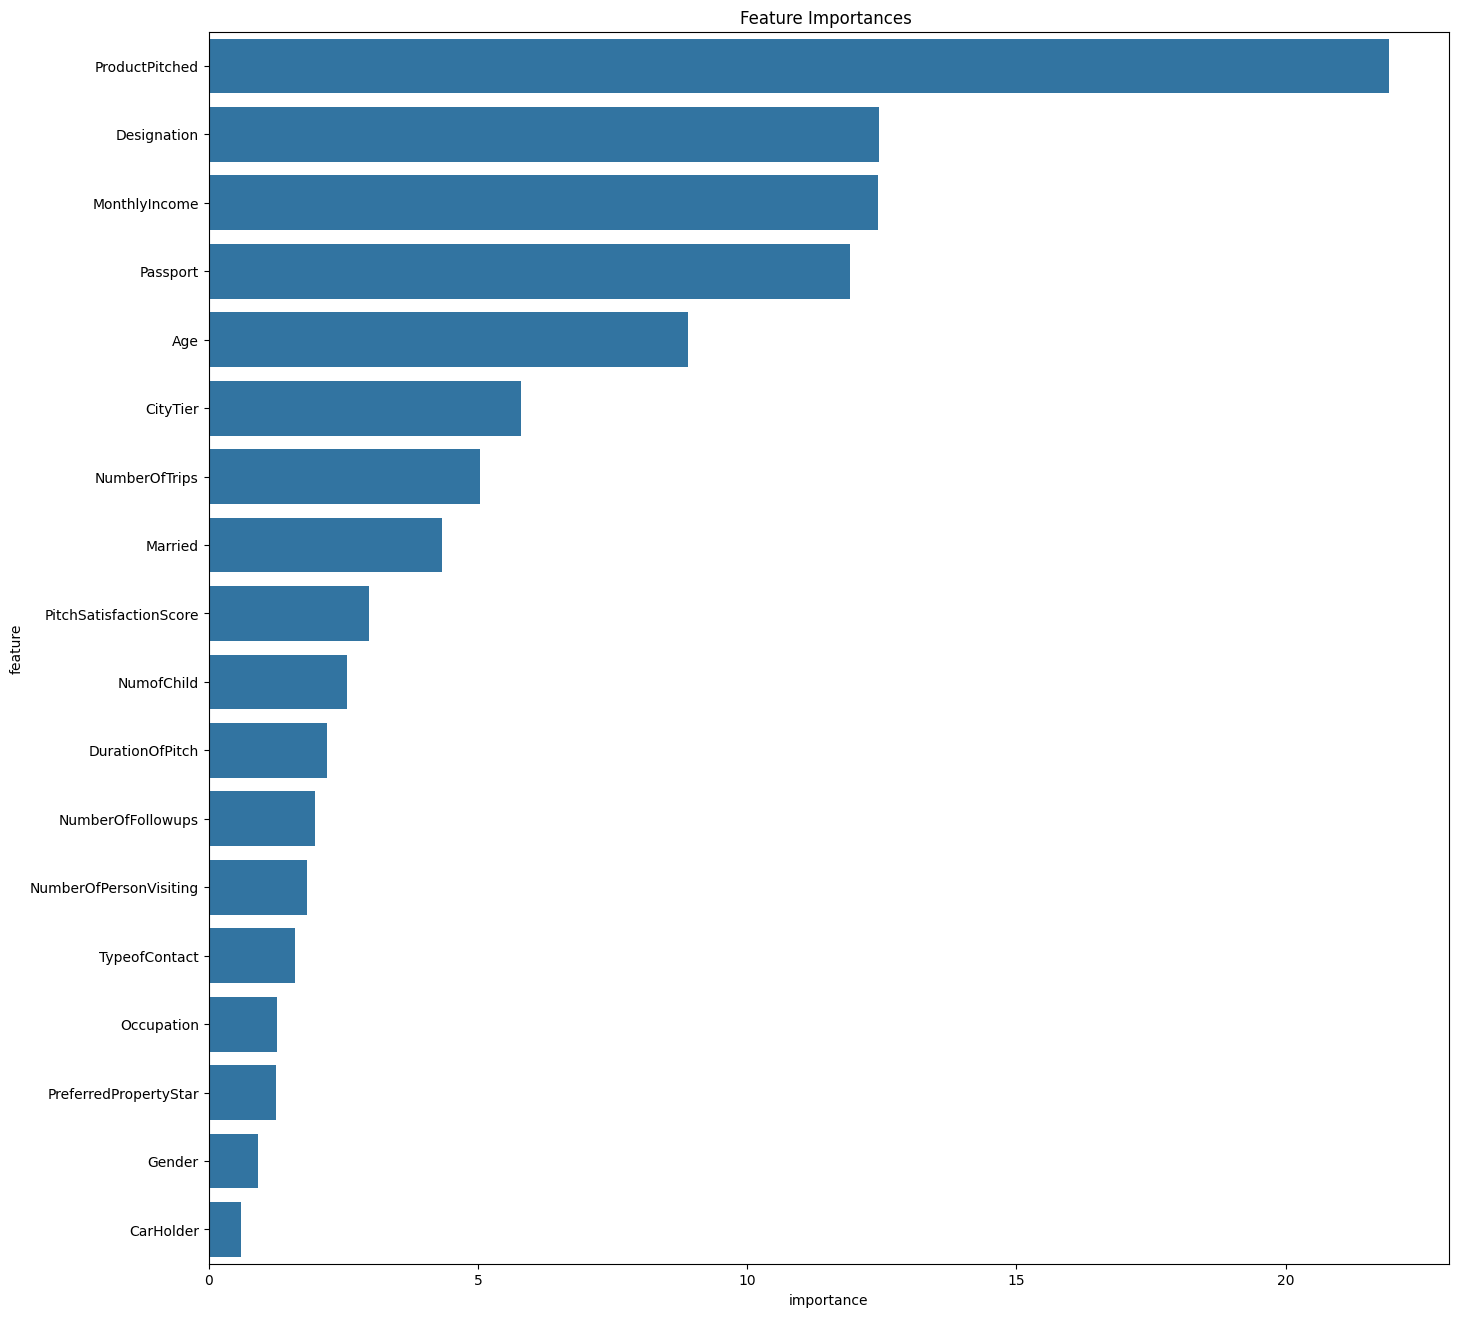

In [ ]:
plt.figure(figsize=(16, 16))
sns.barplot(data=o.sort_values(by='importance', ascending=False), x='importance', y='feature')
plt.title('Feature Importances ')

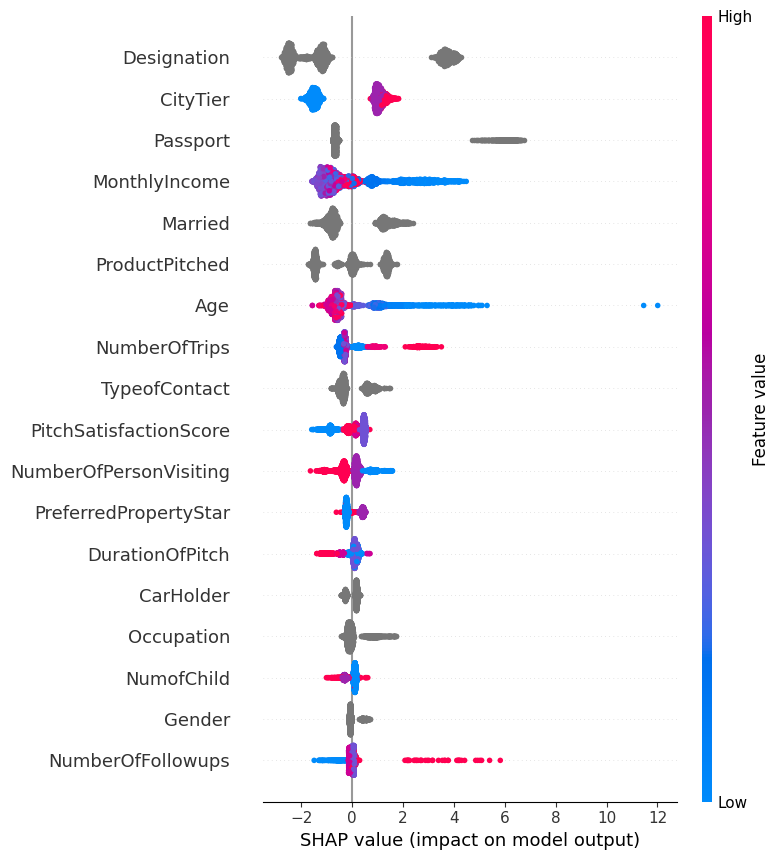

In [ ]:
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt
shap.initjs()

# 各FOLD、SEEDの和 (相対値なのでこれで良しとする)
shapval = 0
for i in range(5):
  explainer = shap.TreeExplainer(models[i])
  shap_values = explainer.shap_values(train.drop("ProdTaken",axis=1))
  shapval = shapval + shap_values

shap.summary_plot(shapval, train.drop("ProdTaken",axis=1))